<a href="https://colab.research.google.com/github/Aksavxavier/Aksa-Villamthanam-Xavier/blob/main/Static_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks (PINNs)

PINNs are a computational framework introduced to solve PDEs by incorporating the laws of physics directly into the neural network's loss function. This reduces the need for labeled training data by enforcing physical constraints. Specifically:

•	PINNs minimize a cost function:

                   C = MSEu + MSEf

o	MSEu: Error at boundary or initial conditions.

o	MSEf: Residual error of the PDE.

•	Advantages :

o	Combines physics with data to model complex systems.

o	Reduces dependency on large labeled datasets.

o	Utilizes automatic differentiation for accurate derivative computation.



# Static Model

The PyTorch implementation uses a Physics-Informed Neural Network (PINN) to solve the Static Bar Problem, a boundary value problem involving differential equations

Epoch 0, Loss: 4037.4931640625
Epoch 100, Loss: 5.338111350283725e-06
Epoch 200, Loss: 5.336757112672785e-06
Epoch 300, Loss: 5.336757112672785e-06
Epoch 400, Loss: 5.336757112672785e-06
Epoch 500, Loss: 5.336757112672785e-06
Epoch 600, Loss: 5.336757112672785e-06
Epoch 700, Loss: 5.336757112672785e-06
Epoch 800, Loss: 5.336757112672785e-06
Epoch 900, Loss: 5.336757112672785e-06


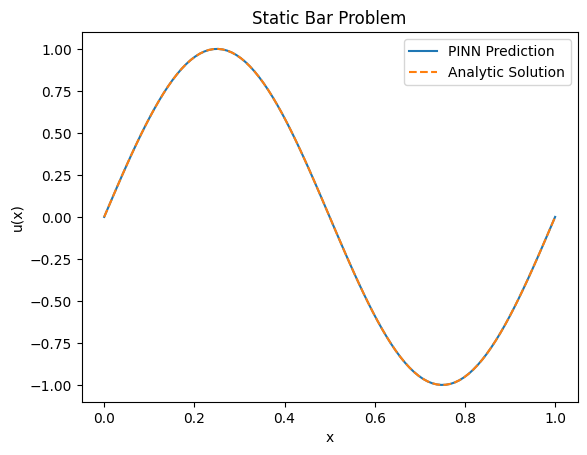

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define the physics loss (f = d/dx(EA * du/dx) + p)
def physics_loss(model, x, EA, p):
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    EA_u_x = EA(x) * u_x
    u_xx = torch.autograd.grad(EA_u_x, x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    f = u_xx + p(x)
    return torch.mean(f**2)

# Define the boundary loss
def boundary_loss(model, boundary_points, boundary_values):
    predictions = model(boundary_points)
    return torch.mean((predictions - boundary_values) ** 2)

# Define material properties and load
EA = lambda x: 1.0  # Constant EA
p = lambda x: 4 * (torch.pi**2) * torch.sin(2 * torch.pi * x)  # Distributed load

# Boundary conditions
boundary_points = torch.tensor([[0.0], [1.0]], requires_grad=True)
boundary_values = torch.tensor([[0.0], [0.0]])

# Generate collocation points
collocation_points = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

# Initialize the model
input_dim = 1
hidden_dim = 10
output_dim = 1
model = PINN(input_dim, hidden_dim, output_dim)

# Define the optimizer
optimizer = optim.LBFGS(model.parameters(), lr=0.1)

# Training loop
def closure():
    optimizer.zero_grad()
    mse_b = boundary_loss(model, boundary_points, boundary_values)
    mse_f = physics_loss(model, collocation_points, EA, p)
    loss = mse_b + mse_f
    loss.backward()
    return loss

# Train the model
for epoch in range(1000):
    optimizer.step(closure)
    if epoch % 100 == 0:
        loss = closure()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict and plot results
import matplotlib.pyplot as plt

x = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x).detach().numpy()
u_analytic = torch.sin(2 * torch.pi * x).numpy()

plt.plot(x.numpy(), u_pred, label="PINN Prediction")
plt.plot(x.numpy(), u_analytic, label="Analytic Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Static Bar Problem")
plt.show()

# **JAX**

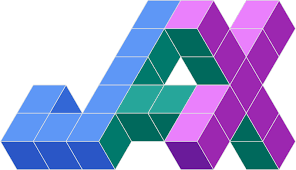

What is JAX?

JAX is Autograd and XLA, brought together for high-performance numerical computing and machine learning research. It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more.

In simpler words: JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.
XLA
XLA: Accelerated Linear Algebra, lies at the foundation of what makes JAX so powerful. Developed by Google, XLA is a domain-specific, graph-based, just-in-time compiler for linear algebra.

It significantly improves execution speed and lowers memory usage by fusing low-level operations.

Replacement for NumPy

Speed up computations with jit()

Automatic Differentiation with grad()

Automatic Vectorization with vmap()

Automatic Parallelization with pmap()

# Example Training Loop with JAX

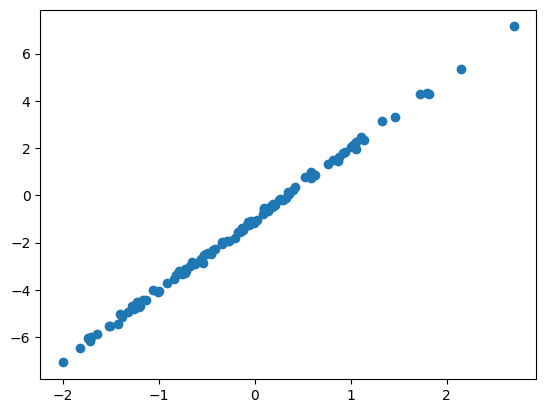

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [ ]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

w: 3.00, b: -0.99
f(x) = 3.00 * x -0.99


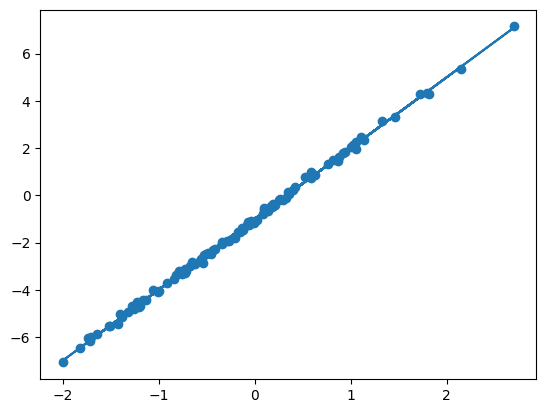

In [ ]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")
print(f"f(x) = {w:<.2f} * x {b:<.2f}")

# The JAX PINN Code for Static Bar Problem

The code uses Physics-Informed Neural Networks (PINNs) with JAX and Flax to solve a 1D static bar problem under distributed loading. The goal is to train the neural network to satisfy both the boundary conditions and the governing differential equation.

Adam Iteration 0, Loss: 768.775391
Adam Iteration 100, Loss: 422.589630
Adam Iteration 200, Loss: 119.488388
Adam Iteration 300, Loss: 66.624832
Adam Iteration 400, Loss: 25.758711
Adam Iteration 500, Loss: 6.321460
Adam Iteration 600, Loss: 1.380746
Adam Iteration 700, Loss: 0.539843
Adam Iteration 800, Loss: 0.333831
Adam Iteration 900, Loss: 0.227958


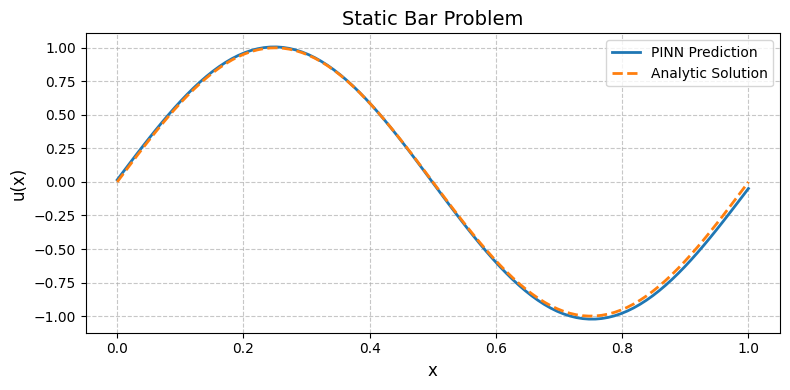

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, vmap
from flax import linen as nn
import optax
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the PINN architecture with increased complexity
class PINN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.tanh(x)
        x = nn.Dense(20)(x)
        x = nn.tanh(x)
        return nn.Dense(1)(x)

# Material properties
EA = lambda x: 1.0
p = lambda x: 4 * (jnp.pi**2) * jnp.sin(2 * jnp.pi * x)

# Initialize model
model = PINN()
key = jax.random.PRNGKey(0)
params = model.init(key, jnp.ones((1, 1)))

# Physics-informed loss
def physics_loss(params, x):
    def u_fn(x_scalar):
        return model.apply(params, jnp.array([[x_scalar]])).squeeze()
    u_xx = grad(grad(u_fn))(x.squeeze())
    return (u_xx + p(x.squeeze()))**2

# Boundary loss with higher weight
boundary_points = jnp.array([[0.0], [1.0]])
boundary_values = jnp.array([0.0, 0.0])

def boundary_loss(params):
    preds = model.apply(params, boundary_points).squeeze()
    return 10 * jnp.mean((preds - boundary_values)**2)

# Total loss with more collocation points
collocation_points = jnp.linspace(0, 1, 200).reshape(-1, 1)

def total_loss(params):
    phys_loss = jnp.mean(vmap(lambda x: physics_loss(params, x))(collocation_points))
    return phys_loss + boundary_loss(params)

# Hybrid Optimizer: Adam followed by L-BFGS
# Step 1: Use Adam Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state):
    loss, grads = jax.value_and_grad(total_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Run Adam for initial optimization
for i in range(1000):
    params, opt_state, loss = train_step(params, opt_state)
    if i % 100 == 0:
        print(f"Adam Iteration {i}, Loss: {loss:.6f}")

# Step 2: Use L-BFGS for fine-tuning
params_flat, unflatten = jax.flatten_util.ravel_pytree(params)
res = minimize(lambda p: total_loss(unflatten(p)), params_flat,
               method='L-BFGS-B', options={'maxiter': 1000, 'disp': True})
params_opt = unflatten(res.x)

# Generate predictions
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
u_pred = model.apply(params_opt, x_plot).squeeze()
u_analytic = jnp.sin(2 * jnp.pi * x_plot).squeeze()

# Plot results with proper styling
plt.figure(figsize=(8, 4))
plt.plot(x_plot, u_pred, label='PINN Prediction', linewidth=2)
plt.plot(x_plot, u_analytic, '--', label='Analytic Solution', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.xticks(jnp.linspace(0, 1, 6))
plt.title('Static Bar Problem', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()